# Анализ пресс-релизов Банка России

**Описание исследования:**

Мы получили тексты пресс-релизов с сайта ЦБ, и теперь хотим увидеть взаимосвязь этих текстов с решением, по ключевой ставке.

**Цель исследования:**

Получить знания, о зависимости текстовых данных пресс-релизов и решениями по ключевой ставки и использовать их в построении модели предсказания ключевой ставки.

**План работы:**
1) Загрузка и предобработка данных.
2) Объединение таблиц и создание целевых переменных.
3) Провести анализ текстов: расчет средней, минимальной и максимальной длины текстов (визуализация
распределения), частотный анализ слов и n-грамм, извлечение биграмм и триграмм, статистики по
символам и словам, распределение частей речи.
4) Изучить связь текстовых признаков с целевой переменной.
5) Визуализировать данные:
    - распределения классов;
    - облако наиболее частотных слов и биграмм для выявления ключевых тем (Word Clouds);
    - методы снижения размерности (например, t-SNE) для визуализации текстовых представлений.
6) Провести первичную предобработку теста:
    - оценить и обработать пропуски, дубликаты; очистить текст от шумовых данных: ненужных символов, HTML-тегов,
специальных символов;
    - преобразовать регистр, исключить стоп-слова, провести токенизацию (разбить на слова, предложения, символы), лемматизацию или стемминг.
7) Оформить вывод о структуре данных, их особенностях и потенциальных проблемах на основе
проведенного разведочного анализа данных.

**Описание данных:**

Данные получены путем скрапинга с официального сайти Центрального банка.

Таблица пресс-релизов(`cbr-press-releases.csv`), содержит следующие столбцы:
- `date` - дата опубликования пресс-релиза;
- `link` - ссылка на пресс-релиз;
- `title` - заголовок пресс-релиза;
- `release` - текст пресс-релиза.

Таблица процентных ставок, содержит следующие столбцы:
- `date` - дата опубликования процентных ставок;
- `rate` - величина процентной ставки;

In [2]:
# импортируем библиотеки
import re

import pandas as pd
import locale
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns


# Устанавливаем тему для графиков
sns.set(style="darkgrid")

## Загрузка и предобработка данных пресс-релизов.

Загрузим данные и взглянем на первые и последние 5 строчек.

In [3]:
df = pd.read_csv('../data/raw-cbr-press-releases.csv')
df

,date,link,title,release
0,13 сентября 2024 г.,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 13 сентября 2024...
1,26 июля 2024 г.,http://www.cbr.ru/press/pr/?file=26072024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 26 июля 2024 год...
2,7 июня 2024 г.,http://www.cbr.ru/press/pr/?file=07062024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 7 июня 2024 года...
3,26 апреля 2024 г.,http://www.cbr.ru/press/pr/?file=26042024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 26 апреля 2024 г...
4,22 марта 2024 г.,http://www.cbr.ru/press/pr/?file=22032024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 22 марта 2024 го...
...,...,...,...,...
95,13 декабря 2013 г.,http://www.cbr.ru/press/pr/?file=131213_133004...,О ключевой ставке Банка России,Совет директоров Банка России 13 декабря 2013 ...
96,8 ноября 2013 г.,http://www.cbr.ru/press/pr/?file=131108_133008...,О ключевой ставке Банка России,Совет директоров Банка России 8 ноября 2013 го...
97,14 октября 2013 г.,http://www.cbr.ru/press/pr/?file=131014_133001...,О ключевой ставке Банка России,"Пресс-служба Банка России сообщает, что Совет ..."
98,13 сентября 2013 г.,http://www.cbr.ru/press/pr/?file=130913_135042...,О системе процентных инструментов денежно-кред...,О системе процентных инструментов денежно-кред...


К ссылкам стоит добавить адрес главной страницы, тексты релизов стоит обработать и убрать лишние символы перевода строки. Дату надо привести к соответствующему типу данных. Посмотрим какие типы данных у наших переменных и количество пропущенных значений.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     100 non-null    object
 1   link     100 non-null    object
 2   title    100 non-null    object
 3   release  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


У нас 100 наблюдений в нашем датасете. Пропущенные значения отсутствуют. Дату, как уже упоминалось выше стоит превести к типу данных `date`.

In [5]:
locale.setlocale(
    category=locale.LC_ALL,
    locale="Russian"
)

def calc_date(value):
    day, month, year, _ = value.split()
    month = month[:3]
    return datetime.strptime(' '.join([day, month, year]), '%d %b %Y')

df.date = df.date.map(calc_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     100 non-null    datetime64[ns]
 1   link     100 non-null    object        
 2   title    100 non-null    object        
 3   release  100 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.3+ KB


Теперь порядок с типами данных. Проверим данные на дубликаты.

In [6]:
print(f'Количество дубликатов по дате и названию - {df.duplicated(subset=["date", "title"]).sum()}')

Количество дубликатов по дате и названию - 0


Посмотрим есть ли у нас релизы опубликованные в один день.

In [7]:
print(f'Количество дубликатов по дате - {df.duplicated(subset=["date"]).sum()}')

Количество дубликатов по дате - 2


Взглянем на эти релизы.

In [8]:
indexes = df[df.duplicated(subset=["date"], keep=False)].index

for index in indexes:
    release = df.loc[index]
    print(release.date)
    print('-' * 80, end=' ')
    for i in range(0, len(release.release), 80):
        
        print(release.release[i:i+80])

2015-09-11 00:00:00
-------------------------------------------------------------------------------- В целях оперативного информирования пользователей о макроэкономических тенденция
х, складывающихся в сфере внешнеэкономической деятельности, Банк России вводит в
 практику ежемесячные сообщения об оценке ключевых агрегатов платежного баланса 
Российской Федерации. 
Данные будут размещаться в рубрике Комментарии Банка Росс
ии раздела Пресс-центр официального сайта Банка России.При использовании материа
ла ссылка на Пресс-службу Банка России обязательна.
2015-09-11 00:00:00
-------------------------------------------------------------------------------- Совет директоров Банка России 11 сентября 2015 года принял решение сохранить клю
чевую ставку на уровне 11,00% годовых, учитывая увеличение инфляционных рисков п
ри сохранении рисков существенного охлаждения экономики. В августе произошло зна
чительное ухудшение внешнеэкономической конъюнктуры. Под воздействием курсовой д
инамики выросла и

Мы можем заметить, что два релиза из четырех не связаны с решением банка россии по ключевой ставке. Удалим эти наблюдения из выборки.

In [9]:
df.drop_duplicates(subset=['date'], keep='last', inplace=True)

У нас есть пресс-релизы, которые не связаны с изменением процентной ставки, посмотрим на них.

In [10]:
indexes = df[df.title.str.contains('О публикации Обзора ключевых показателей') | df.title.str.contains('О фиксированном времени публикации ключевой')].index
for index in indexes:
    release = df.loc[index]
    print(release.date)
    print('-' * 80)
    print(release.release)

2015-12-29 00:00:00
--------------------------------------------------------------------------------
Банк России, следуя наилучшим практикам распространения данных, с 1 января 2016 года вводит единый порядок публикации ключевой информации по статистике внешнего сектора — данные будут размещаться на официальном сайте Банка России в фиксированное время 16.00 мск. 
Даты публикации статистических данных, размещаемых в фиксированное время, содержатся в Календаре публикаций официальной статистической информации: 
http://www.cbr.ru/statistics/indcalendar/.
Новый порядок публикации обеспечит пользователям более удобные условия получения ключевой статистической информации и позволит эффективно планировать работу с этими данными.При использовании материала ссылка на Пресс-службу Банка России обязательна.
2015-05-06 00:00:00
--------------------------------------------------------------------------------
Банк России начинает публиковать на официальном сайте в информационно-телекоммуникационной се

Удалим эти наблюдения.

In [11]:
df = df[~(df.title.str.contains('О публикации Обзора ключевых показателей') | df.title.str.contains('О фиксированном времени публикации ключевой'))]

In [12]:
df

,date,link,title,release
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 13 сентября 2024...
1,2024-07-26,http://www.cbr.ru/press/pr/?file=26072024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 26 июля 2024 год...
2,2024-06-07,http://www.cbr.ru/press/pr/?file=07062024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 7 июня 2024 года...
3,2024-04-26,http://www.cbr.ru/press/pr/?file=26042024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 26 апреля 2024 г...
4,2024-03-22,http://www.cbr.ru/press/pr/?file=22032024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 22 марта 2024 го...
...,...,...,...,...
94,2014-02-14,http://www.cbr.ru/press/pr/?file=14022014_1333...,О ключевой ставке Банка России,Совет директоров Банка России 14 февраля 2014 ...
95,2013-12-13,http://www.cbr.ru/press/pr/?file=131213_133004...,О ключевой ставке Банка России,Совет директоров Банка России 13 декабря 2013 ...
96,2013-11-08,http://www.cbr.ru/press/pr/?file=131108_133008...,О ключевой ставке Банка России,Совет директоров Банка России 8 ноября 2013 го...
97,2013-10-14,http://www.cbr.ru/press/pr/?file=131014_133001...,О ключевой ставке Банка России,"Пресс-служба Банка России сообщает, что Совет ..."


## Загрузка и предобработка данных величины ключевых ставок.

Загрузим данные и посмотрим на первые и последние пять строчек.

In [13]:
df_rates = pd.read_csv('../data/key-rates-cbr.csv')
df_rates

,date,rate
0,17.09.2013,5.5
1,18.09.2013,5.5
2,19.09.2013,5.5
3,20.09.2013,5.5
4,23.09.2013,5.5
...,...,...
2769,14.10.2024,19.0
2770,15.10.2024,19.0
2771,16.10.2024,19.0
2772,17.10.2024,19.0


На первый взляд ошибок нет. Посмотрим общую информацию о таблице.

In [14]:
df_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2774 entries, 0 to 2773
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2774 non-null   object 
 1   rate    2774 non-null   float64
dtypes: float64(1), object(1)
memory usage: 43.5+ KB


Пропущенные значения отсутствуют, а вот дату стоит привести к формату даты.

In [15]:
df_rates.date = pd.to_datetime(df_rates.date, dayfirst=True)

Проверим данные на дубликаты по дате.

In [16]:
print(f'Количество дубликатов дат -', end=' ')
print(f'{df_rates.duplicated(subset="date").sum()}')

Количество дубликатов дат - 0


В таблице процентных ставок, ставка в день релиза не изменяется, а изменяется только на следующий день. Давайте сдвинем дату на 2 строчки.

In [17]:
df_rates.date = df_rates.date.shift(2)

## Объединение таблиц и cоздание целевых переменных.

Объеденим наши данные по дате.

In [18]:
df = df.merge(right=df_rates, how='left', on='date')
df

,date,link,title,release,rate
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 13 сентября 2024...,19.0
1,2024-07-26,http://www.cbr.ru/press/pr/?file=26072024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 26 июля 2024 год...,18.0
2,2024-06-07,http://www.cbr.ru/press/pr/?file=07062024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 7 июня 2024 года...,16.0
3,2024-04-26,http://www.cbr.ru/press/pr/?file=26042024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 26 апреля 2024 г...,16.0
4,2024-03-22,http://www.cbr.ru/press/pr/?file=22032024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 22 марта 2024 го...,16.0
...,...,...,...,...,...
91,2014-02-14,http://www.cbr.ru/press/pr/?file=14022014_1333...,О ключевой ставке Банка России,Совет директоров Банка России 14 февраля 2014 ...,5.5
92,2013-12-13,http://www.cbr.ru/press/pr/?file=131213_133004...,О ключевой ставке Банка России,Совет директоров Банка России 13 декабря 2013 ...,5.5
93,2013-11-08,http://www.cbr.ru/press/pr/?file=131108_133008...,О ключевой ставке Банка России,Совет директоров Банка России 8 ноября 2013 го...,5.5
94,2013-10-14,http://www.cbr.ru/press/pr/?file=131014_133001...,О ключевой ставке Банка России,"Пресс-служба Банка России сообщает, что Совет ...",5.5


Создадим переменную `target` которая будет показывать насколько изменится процентная ставка на следующем решении.

In [19]:
df['target'] = df.rate.shift(1) - df.rate
df

,date,link,title,release,rate,target
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 13 сентября 2024...,19.0,NaN
1,2024-07-26,http://www.cbr.ru/press/pr/?file=26072024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 26 июля 2024 год...,18.0,1.0
2,2024-06-07,http://www.cbr.ru/press/pr/?file=07062024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 7 июня 2024 года...,16.0,2.0
3,2024-04-26,http://www.cbr.ru/press/pr/?file=26042024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 26 апреля 2024 г...,16.0,0.0
4,2024-03-22,http://www.cbr.ru/press/pr/?file=22032024_1330...,Банк России принял решение сохранить ключевую ...,Совет директоров Банка России 22 марта 2024 го...,16.0,0.0
...,...,...,...,...,...,...
91,2014-02-14,http://www.cbr.ru/press/pr/?file=14022014_1333...,О ключевой ставке Банка России,Совет директоров Банка России 14 февраля 2014 ...,5.5,1.5
92,2013-12-13,http://www.cbr.ru/press/pr/?file=131213_133004...,О ключевой ставке Банка России,Совет директоров Банка России 13 декабря 2013 ...,5.5,0.0
93,2013-11-08,http://www.cbr.ru/press/pr/?file=131108_133008...,О ключевой ставке Банка России,Совет директоров Банка России 8 ноября 2013 го...,5.5,0.0
94,2013-10-14,http://www.cbr.ru/press/pr/?file=131014_133001...,О ключевой ставке Банка России,"Пресс-служба Банка России сообщает, что Совет ...",5.5,0.0


In [20]:
df[df.target.isna()]

,date,link,title,release,rate,target
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 13 сентября 2024...,19.0,NaN
95,2013-09-13,http://www.cbr.ru/press/pr/?file=130913_134305...,О процентных ставках по операциям Банка России,Департамент внешних и общественных связей Банк...,NaN,NaN


У нас получилось 2 пропущенных значения в переменной `target`. Самое последнее наблюдение, потому что мы не знаем следующего решения по ключевой ставки, удалим это наблюдение. А пропуск в самом первом наблюдении заполним нулем, так как мы знаем, что следующее решение было сохранить процентную ставку. 

In [21]:
df.loc[df.date == df.date.min(), 'rate'] = 5.5
df.loc[df.date == df.date.min(), 'target'] = 0
df.dropna(subset=['target'], inplace=True)

Создадим переменную `target_category`, которая будет равна 1 если `target` положительный, -1 если `target` отрицательный и 0 если `target` рпавен 0.

In [33]:
def calc_target_category(value):
    if value > 0:
        return 1
    elif value < 0:
        return -1
    else:
        return 0
    

df['target_category'] = df.target.map(calc_target_category)

## Исследовательский анализ.

In [34]:
COLORS = {
    0: '#1A4E1A',
    1: '#A03B2A',
    -1: '#4D6D7F'
}

### Распределение целевой переменной.

Посмотрим как распределена переменная `target`.

Общее количество наблюдений - 95


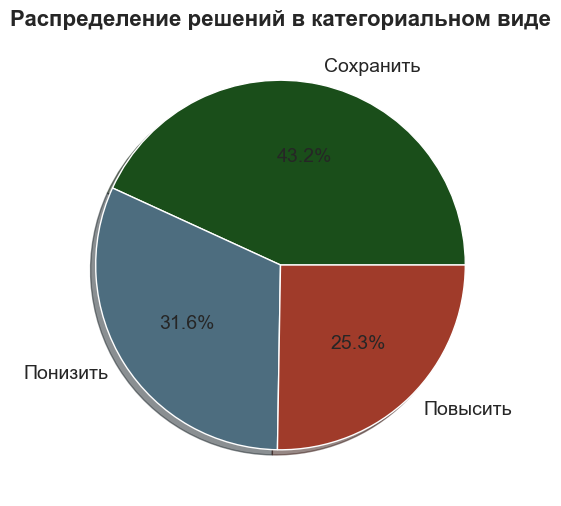

In [35]:
data = df.target_category.value_counts().reset_index()
print(f'Общее количество наблюдений - {df.shape[0]}')
colors = [COLORS[0], COLORS[-1], COLORS[1]]

# Создаем круговую диаграмму
plt.figure(figsize=(6, 6))  # Устанавливаем размер фигуры
plt.pie(
    data['count'], 
    labels=['Сохранить', 'Понизить', 'Повысить'], 
    colors=colors, 
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
    shadow=True,
)

# Устанавливаем заголовок
plt.title(
    'Распределение решений в категориальном виде', 
    fontsize=16,
    fontweight="bold"
)

# Отображаем диаграмму
plt.show()

Наблюдается, небольшой дисбаланс классов, у нас больше всего наблюдений с решением сохранить ключевую ставку, а меньше всего повысить.

Посмотрим распределение длин текстов пресс-релизов.

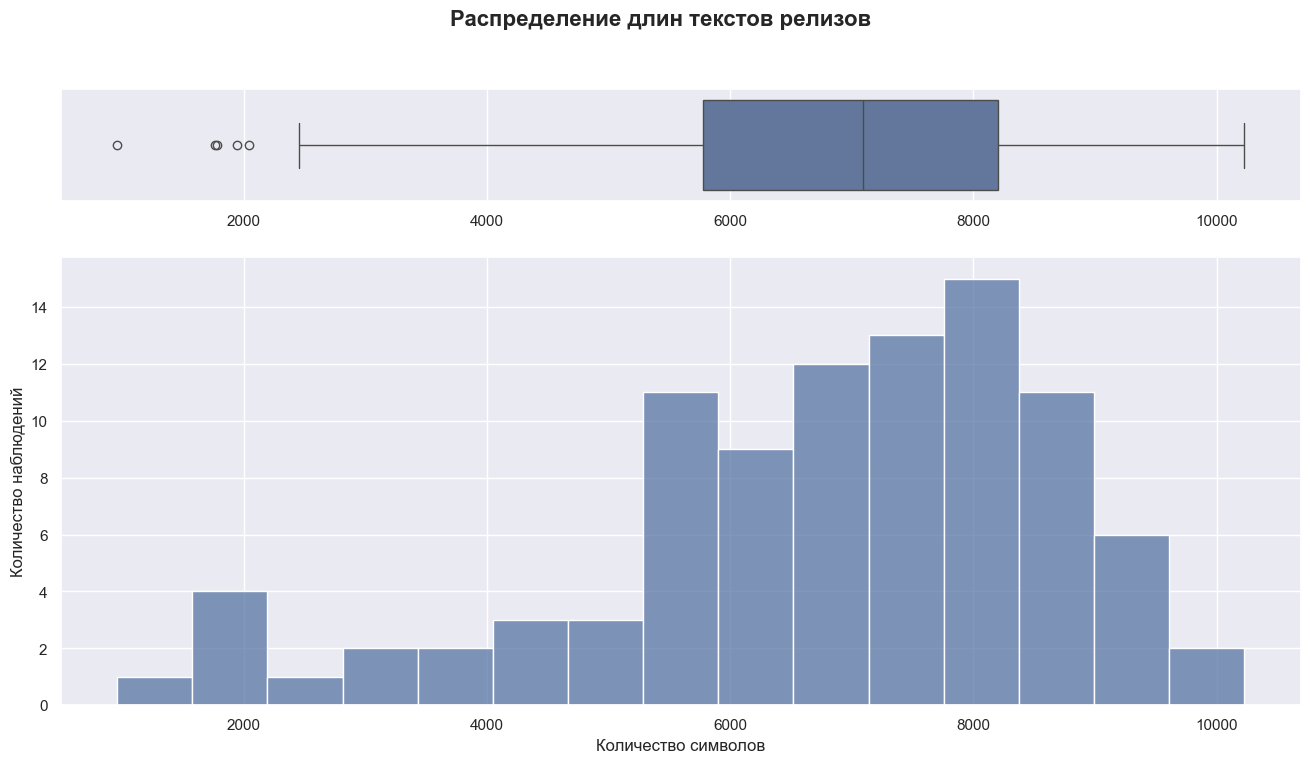

Средняя длина текстов - 6766.88 символов
Самый длинный текст - 10227 символов
Самый короткий текст - 960 символов


In [36]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=False, 
    gridspec_kw={"height_ratios": (.2, .8)},
    figsize=(16, 8)
)

sns.boxplot(
    data=df, 
    x=df.release.str.len(), 
    ax=axes[0], 
    orient='h', 
    color='#5975A4',
)

sns.histplot(
    data=df, 
    x=df.release.str.len(), 
    color='#5975A4',
    bins=15
    )

axes[0].set_xlabel('')
axes[1].set_ylabel('Количество наблюдений', fontsize=12)
axes[1].set_xlabel('Количество символов', fontsize=12)

fig.suptitle('Распределение длин текстов релизов', 
            fontsize=16,
            fontweight="bold",
)
plt.show()
print(f'Средняя длина текстов - {df.release.str.len().mean():.2f} символов')
print(f'Самый длинный текст - {df.release.str.len().max()} символов')
print(f'Самый короткий текст - {df.release.str.len().min()} символов')

Можно заметить, что как правило длина релизов составляет от 5500 символов до 9000 символов. Посмотрим распределение длины текстов, в разрезе целевой переменной.

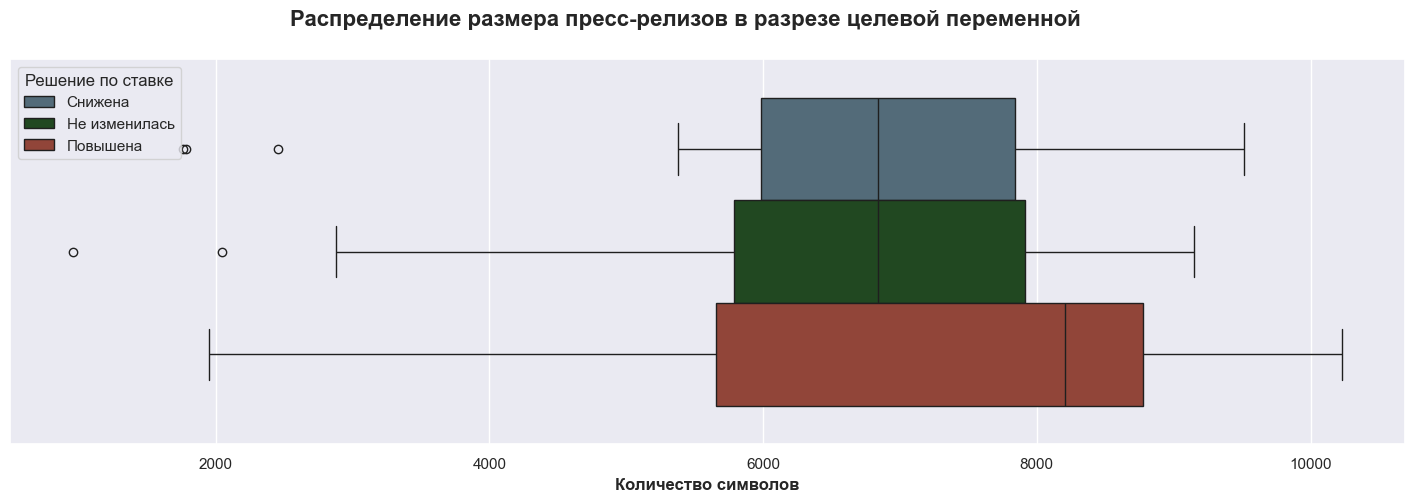

In [38]:
# Устанавливаем размер графика
plt.figure(figsize=(18, 5))

# Строим гистограмму для числового признака с разделением по признаку оттока (churn)
sns.boxplot(
    data=df, 
    x=df.release.str.len(), 
    hue='target_category', 
    palette=COLORS,
    )

# Устанавливаем заголовок графика
plt.suptitle(
    'Распределение размера пресс-релизов в разрезе целевой переменной', 
    fontsize=16, 
    fontweight='bold'
)

# Устанавливаем название оси X
plt.xlabel('Количество символов', fontweight='bold')

# Устанавливаем название оси Y
plt.ylabel('')

# Настройка легенды
plt.legend(
    title='Решение по ставке',              
    labels=['Снижена', 'Не изменилась', 'Повышена'],                     
)

# Отображаем график
plt.show()

Можем заметить, что за длинными релизами чаще следует повышение ключевой ставки. 